## Matrix Product States

In [1]:
# in case needed, sometimes the figures can be drawn with a seperate window
# the following two command enforces it to draw 'inline'
%matplotlib
%matplotlib inline
# ignore the warnings: can be useful for too many imag. part warnings 
import warnings
warnings.filterwarnings('ignore')
from numpy import *
from scipy import *
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pylab import * # for plotting commands
import matplotlib.pyplot as plt
from numpy import (real,imag,matrix,linspace,array,complex)
from IPython.display import Image
from mpl_toolkits.mplot3d import axes3d
from ncon import ncon

Using matplotlib backend: Qt5Agg


Before going into the full details of the DMRG algorithms, it is useful to have a full understanding of the matrix product states and operators, MPSs and MPOs respectively.

#### MPSs

The matrix product states are approximations to an N-body Hilbert state vectors of size $2^N$. It consists of the multiplication of N matrices, $A^{\sigma_n}$:

\begin{eqnarray}
\mid \psi \rangle &=& \sum_{\{ \sigma \}} A^{\sigma_1} A^{\sigma_2} A^{\sigma_3} ... A^{\sigma_{N-1}}A^{\sigma_{N}} \mid \sigma_1 \sigma_2 \sigma_3 ... \sigma_{N-1} \sigma_N \rangle\\
&=&  \sum_{\{ \sigma \}\{i\}} A^{\sigma_1}_{ i_1} A^{\sigma_2}_{i_1 i_2} A^{\sigma_3}_{i_2 i_3} ... A^{\sigma_{N-1}}_{i_{N-1} i_{N}}A^{\sigma_{N}}_{i_{N}} \mid \sigma_1 \sigma_2 \sigma_3 ... \sigma_{N-1} \sigma_N \rangle.
\end{eqnarray}

For this purpose let us generate an N-body tuple and SVD or polar decomposite it to form into the center of orthogonality w.r.t. right most element.

Let us say we have a 6-site lattice, we then generate 6-random tensors: 

In [2]:
N = 42
chi = 8

In [3]:
A = [0 for x in range(N)]

In [4]:
chid = 2
A[0] = np.random.rand(1,chid,min(chi,chid))
for i0 in range(1,N):
    intnum=A[i0-1].shape[2]
    A[i0]= np.random.rand(intnum,chid,min(min(chi,chid*intnum),chid**(N-i0-1)))

Make it into right orthogonal form.

The recipe: 
- Take the SVD of each site one-by-one $USV^\dagger = M_i$, while keeping the unitary part as the new matrix on that site $M'_i = U$, we multiply $SV^\dagger$ part into $M_{i+1}$. Then, new matrix is $M'_{i+1} = SV^\dagger M_{i+1}$

In [5]:
for i0 in range(N-1):
    Aint = A[i0]; indcs = A[i0].shape
    kayL = Aint.shape[0];kayR = Aint.shape[2]
    indcs = Aint.shape
    ind1 = prod(indcs)/indcs[-1]
    Aint1 = A[i0+1]
    u, s, vh = np.linalg.svd(reshape(Aint,(int(ind1),int(indcs[-1]))), full_matrices = False)

    A[i0] = u.reshape(kayL,chid,kayR)
    cc = diag(s)@vh
    A[i0+1] = tensordot(cc,Aint1, axes=([1],[0]))/norm(s)
    
# apply  the same procedure to the last site
Aint = A[N-1]; indcs = A[N-1].shape
kayL = Aint.shape[0];kayR = Aint.shape[2]
Aint = A[N-1]
indcs = Aint.shape
ind1 = prod(indcs)/indcs[-1]
u, s, vh = np.linalg.svd(reshape(Aint,(int(ind1),int(indcs[-1]))), full_matrices = False)
A[N-1] = u.reshape(kayL,chid,kayR)
sWeight = [0 for x in range(N+1)]
print(s.shape,vh.shape)
sWeight[N] =  diag(s)@vh/norm(s)

(1,) (1, 1)


What about the shapes of each matrices? Let me print the shapes

In [6]:
for i0 in arange(N):
    print(np.array(A[i0]).shape)

(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)


What is special about this left or right "canonical form"s (in our case it is left, where it could also be "mixed")? 
- Answer: The inner product of each matrix is identity. It means when one applies the local operators $\langle \psi |\vec{S}_i \cdot \vec{S}_{i+1}| \psi \rangle$, because the active sites that the operators are applied $(i,i+1)$, the rest of the inner products will result in an identity matrix.

In [7]:
Bn = [0 for x in range(N)]
for i0 in arange(N):
    Aint = A[i0]
    Bn[i0]=(fix(1e12*tensordot(Aint,conj(Aint), axes=([0,1],[0,1])))/1e12)

We make the random MPS "left-orthogonal", we check it by contracting from the left where each contraction must result in identity matrices (except right most site). Below, we print the diagonals

In [8]:
for i0 in arange(N):
    print(diag(Bn[i0]))

[1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1.]
[1

It is now in right-orthogonal form. Now, it is time to generate the matrix product operators (MPOs).

#### MPOs

The matrix product states, unlike the MPSs being variational, are fixed operators.

Consider the Heisenberg chain, it basically consists of local operators (short length interactions). Similar to the wavefunctions, the Hamiltonian can also be expressed as the matrix product operators. The central object is 2-site operator: $\vec{S}_i \cdot \vec{S}_{i+1}$. Adding bunch of identity operators to the left and right of it, we generate all the local operators for $H$.


By using the idea of finite state machines, it is possible to generate the matrix product operators easily. For details please see:
- arXiv:0708.1221
- arXiv:1512.03318v2
- arXiv:1611.02498v2

<img src="FSMmatrix.bmp" width="680">

For multi-dimensional matrices, we need a more general way to contract the tensors. 

In [9]:
J = 1.; Jz=1.
sP = np.array([[0.,0.],[1.,0.]])
sM = np.array([[0.,1.],[0.,0.]])
sX = np.array([[0.,0.5],[0.5,0.]])
sY = np.array([[0.,-0.5j],[0.5j,0.]])
sZ = np.array([[0.5,0.],[0.,-0.5]])
sI = eye(2)

In [10]:
M = zeros((5,5,2,2),dtype="complex")
L1 = len(M)
M[0,0,:,:] = sI;   M[4,4,:,:] = sI;
M[0,1,:,:] = J*sP; M[1,4,:,:] = sM;
M[0,2,:,:] = J*sM; M[2,4,:,:] = sP;
M[0,3,:,:] = Jz*sZ;M[3,4,:,:] = sZ;	 

Yet, beware that the multplication of the matrices does not provide more than what we need, we therefore must sandwich the product of matrix products with left and right vectors, $L$ and $R$. They are also called as the environment matrices in the bulk.

In [11]:
ML = zeros((L1,1,1),dtype="complex"); MR = ML; 
ML[0,0,0] = 1.; MR[L1-1,0,0] = 1.;
Lm = [0 for x in range(N)]; Rm = [0 for x in range(N)];
Lm[0] = ML; Rm[N-1] = MR

#### DMRG Routine
We are ready to do the DMRG routine! At each step, we will focus on 2-site, which in total makes $N-1$ steps! Yet, let me first  arrange the environment matrices:

In [12]:
i5 = 1
print(sWeight[N].shape,Lm[i5-1].shape,M.shape,A[i5-1].shape)

(1, 1) (5, 1, 1) (5, 5, 2, 2) (1, 2, 2)


In [13]:
for i0 in arange(1,N-1):
    #print(L[i0-1].shape,M.shape,A[i0-1].shape,A[i0-1].conj().shape)
    Lm[i0] = ncon([Lm[i0-1],M,A[i0-1],conj(A[i0-1])],\
                 ((1,2,3),(1,-1,5,4),(3,4,-3),(2,5,-2)))

Before we start, let me define my Lanczos function to use in each step, to calculate the GS energy and the wavefunction:

In [14]:
def LancFirat(H,v0,Logsensitivity):
    aN = H.shape[0]
    v0 = reshape(v0,(aN,))/norm(v0)
    threshold = 1e-2
    error = 1.
    count = 0
    maxIt = min(aN,100)
    ee0,ee1,eer0,eer1 = [np.array(zeros((maxIt,),dtype='double')) for _ in range(4)]

    k = 1
    erLog = 1
    Trank = 1
    while erLog>Logsensitivity and k<maxIt:
        MM = min(k,2)
        vjVec = np.array(zeros((aN,k),dtype='complex')) 
        aVec,bVec = [np.array(zeros((k,),dtype='complex')) for _ in range(2)]
        vjVec[:,0] = v0
        if k==1:
            vjVec[:,0] = v0
        else:
            vjVec[:,0:MM] = vv[:,0:MM]
        wjp = dot(H,vjVec[:,0])
        aVec[0]= dot(conj(wjp).T,vjVec[:,0])
        wj = wjp - aVec[0]*vjVec[:,0]

        for i2 in arange(1,k):
            bVec[i2] = norm(wj)
            if bVec[i2] != 0.:
                vj = wj/bVec[i2]
            else:
                vj = np.random.rand(aN,)
                print(i2)
            vSub = np.array(zeros((aN,),dtype='complex'))
            for i3 in arange(i2):
                vSub = vSub + dot(vjVec[:,i3],vj)*vjVec[:,i3]
            vj = vj-vSub 
            vj= vj#/norm(vj)

            vjVec[:,i2] = vj
            wjp= dot(H,vj)
            aVec[i2] = dot(conj(wjp).T,vj)
            wj = wjp - aVec[i2]*vj - bVec[i2]*vjVec[:,i2-1]

        T = diag(aVec)+diag(bVec[1:],1)+diag(bVec[1:],-1)
        
        etI1,vtI1 = eig(T)
        ndee=argsort(etI1)
        vtI1 = vtI1[:,ndee[0:MM]]
        etI1 = etI1[ndee[0:MM]]

        error = norm(bVec)
        Trank = matrix_rank(vjVec)
        vv= dot(vjVec,vtI1)
        
        if k  == 1:
            erLog = 1
        else:
            eer0[k-1] = norm(etI1[0]*dot(vjVec,vtI1[:,0])-dot(H,dot(vjVec,vtI1[:,0])))
            eer1[k-1] = norm(etI1[1]*dot(vjVec,vtI1[:,1])-dot(H,dot(vjVec,vtI1[:,1])))
            erLog = log(eer0[k-1]+eer1[k-1])
        k += 1
    return vv,etI1[0]

Let us start the sweeping from right to left:
- 1. Generate the local wavefunction for the 2-site system:

In [15]:
Ekeep = np.array([])
B = A
chid = M.shape[2]
print("L","M","M","R")
for i0 in arange(N-2,-1,-1):
    kL = A[i0].shape[0];    
    kR = A[i0+1].shape[-1]
    psi2site = ncon([A[i0],A[i0+1],sWeight[i0+2]],((-1,-2,1),(1,-3,2),(2,-4)))
    psi2site = reshape(psi2site,(kL*kR*chid**2,1))
    #print(Lm[i0].shape,M.shape,M.shape,Rm[i0+1].shape)
    H = reshape(ncon([Lm[i0],M,M,Rm[i0+1]],((1,-5,-1),(1,2,-6,-2),(2,3,-7,-3),(3,-8,-4))),(psi2site.shape[0],psi2site.shape[0]))
    psiUpd,e00 = LancFirat(H,psi2site,-10)
    Ekeep = np.append(Ekeep,e00)
    #print(H.shape,psiUpd.shape)
    u, s, vh = np.linalg.svd(reshape(psiUpd[:,0],(kL*chid,kR*chid)), full_matrices=False)
    dimR = min(len(s),chi)
    B[i0+1] = vh[range(dimR),:].reshape(dimR,chid,kR)
    sWeight[i0+1] = diag(s[range(dimR)])/norm(s[range(dimR)])*1.
    A[i0] = u[:,range(dimR)].reshape(kL,chid,dimR)
    Rm[i0] = ncon([M,Rm[i0+1],B[i0+1],conj(B[i0+1])],\
                  ((-1,1,2,3),(1,4,5),(-3,3,5),(-2,2,4)))
kL = A[i0].shape[0];    kR = A[i0].shape[-1]
Aint = ncon([A[i0],sWeight[i0+1]],((-1,-2,1),(1,-3))).reshape(kL,kR*chid)
u, s, vh = np.linalg.svd(Aint, full_matrices=False)
B[0] = vh.reshape(kL,chid,kR)
sWeight[0] = u@(diag(s)/norm(s))

L M M R


Now, ideally, we are supposed to obtain an optimized wavefunction by right-to-left sweeping. Now we need to repeat the sweeping several times L-to-R, R-to-L and so on.

- Left to Right Sweep

In [16]:
Lm[0].shape

(5, 1, 1)

In [17]:
for i0 in range(N-1):
    kL = B[i0].shape[0];    kR = B[i0+1].shape[-1]
    psi2site = ncon([sWeight[i0],B[i0],B[i0+1],],((-1,1),(1,-2,2),(2,-3,-4)))
    psi2site = reshape(psi2site,(kL*kR*chid**2,1))
    Hint = ncon([Lm[i0],M,M,Rm[i0+1]],((1,-5,-1),(1,2,-6,-2),(2,3,-7,-3),(3,-8,-4)))
    #print(Lm[i0].shape,M.shape,M.shape,Rm[i0+1].shape,psi2site.shape,Hint.shape)
    H = Hint.reshape(psi2site.shape[0],psi2site.shape[0])
    psiUpd,e00 = LancFirat(H,psi2site,-10)
    Ekeep = np.append(Ekeep,e00)
    u, s, vh = np.linalg.svd(reshape(psiUpd[:,0],(kL*chid,kR*chid)), full_matrices=False)
    dimR = min(len(s),chi)
    A[i0] = u[:,range(dimR)].reshape(kL,chid,dimR)
    B[i0+1] = vh[range(dimR),:].reshape(dimR,chid,kR)
    sWeight[i0+1] = diag(s[range(dimR)])/norm(s[range(dimR)])*1.
    Lm[i0+1] = ncon([Lm[i0],M,A[i0],conj(A[i0])],\
                  ((1,2,3),(1,-1,4,5),(3,5,-3),(2,4,-2)))
i0 = N-1
kL = B[i0].shape[0];    kR = B[i0].shape[-1]
Aint = ncon([sWeight[i0],B[i0]],((-1,1),(1,-2,-3))).reshape(kL,kR*chid)
u, s, vh = np.linalg.svd(Aint, full_matrices=False)
A[i0] = u.reshape(kL,chid,kR)
sWeight[i0] = (diag(s)/norm(s))@vh

(-0.34654389730002755+0j)


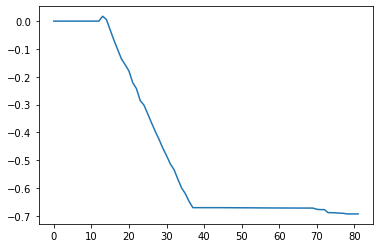

In [18]:
Ekeep1 = np.array(Ekeep)
plot(Ekeep1/(1.*N))
print(Ekeep1[-1]/N/2)

In [27]:
Bn = [0 for x in range(N)]
for i0 in arange(N):
    Aint = np.array(A[i0])
    Bn[i0]=np.round(1e12*tensordot(Aint,conj(Aint), axes=([0,1],[0,1]))/1e12)
    print(diag(Bn[i0]))

[1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0